# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu. It is updated weekly and I last downloaded the dataset on 8/10/2020.  



## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q5"> 5. What significant does the family violence factor play, in violent crime, over time? 
><li><a href="#q6"> 6. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is update weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I originally attempted importing the data into this notebook using Sodapy's Socrata API method but found it cumbersome. Mainly, it didn't want to work with importing the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import mplleaflet as mpll
import contextily as cxt
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from shapely import speedups

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 
              None)

color = ['magenta', 'red', 'blue', 'yellow']

In [2]:
plt.style.use('seaborn-dark-palette')

In [3]:
# Loading the data
df = pd.read_csv('datasets\crime_reports.csv')

In [4]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263567 entries, 0 to 2263566
Data columns (total 27 columns):
Incident Number                int64
Highest Offense Description    object
Highest Offense Code           int64
Family Violence                object
Occurred Date Time             object
Occurred Date                  object
Occurred Time                  float64
Report Date Time               object
Report Date                    object
Report Time                    float64
Location Type                  object
Address                        object
Zip Code                       float64
Council District               float64
APD Sector                     object
APD District                   object
PRA                            object
Census Tract                   float64
Clearance Status               object
Clearance Date                 object
UCR Category                   object
Category Description           object
X-coordinate                   float64
Y-coordin

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20853
Address                             12
Zip Code                         13771
Council District                 46827
APD Sector                        8751
APD District                      9220
PRA                              10443
Census Tract                   1386462
Clearance Status                602249
Clearance Date                  333036
UCR Category                   1494604
Category Description           1494604
X-coordinate                      9856
Y-coordinate                      9856
Latitude                         38152
Longitude                

## II. Data Scrubbing

There are several columns of data we won't be using in the analysis, mainly other date and geodata columns. So we'll drop those and also scrub some others. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The Clearance Status column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed the column to bool with Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am incompletely sure how best to handle this so I am open to suggestions or advice.   

In [5]:
# Helper function for scrubbing the data
def clean_data(df):
    drop_col = ['Occurred Date Time', 
                'Occurred Time', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate', 
                'Location']
    df.drop(drop_col, 
            axis=1, 
            inplace=True)
    clean_col = ['Zip Code', 
                 'Report Date Time',  
                 'PRA'] 
    df.dropna(subset=clean_col, 
              inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    """Convert the following to bools"""
    d = {'Y': True, 
         'N': False}
    e = {'C': True, 
         'O': True, 
         'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence = df.family_violence.map(d)
    df.family_violence = df.family_violence.astype('bool') 
    """Convert the following to datetime type"""
    date_col = ['occurred_date', 
                'clearance_date', 
                'report_date_time'] 
    """Convert the following to category type"""
    cat_col = ['highest_offense_description', 
               'location_type', 
               'apd_sector'] 
    df[date_col] = df[date_col].astype('datetime64') 
    df[cat_col] = df[cat_col].astype('category') 
    """Convert the following to integer type"""
    int_col = ['zip_code', 
               'pra']
    df[int_col] = df[int_col].astype('int64')
    """Create a month column for later use in the analysis"""
    df['month'] = df['report_date_time'].dt.month
    """Set the index"""
    df.set_index(['report_date_time'], 
                 inplace=True)
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

In [6]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
occurred_date                       0
location_type                   20457
address                             0
zip_code                            0
council_district                33055
apd_sector                          0
apd_district                        0
pra                                 0
clearance_status                    0
clearance_date                 329885
latitude                        27542
longitude                       27542
month                               0
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
occurred_date                  datetime64[ns]
location_type                        category
address                                object
zip_code                                int64
council_district                      float64
apd_sector                           category
apd_district                           object
pra                                     int64
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
month                                   int64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,occurred_date,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,month
report_date_time,,,,,,,,,,,,,,,,,
2002-11-29 05:30:00,2002923330284,FAMILY DISTURBANCE,3400,False,2003-01-29,RESIDENCE / HOME,6263 MC NEIL DR,78727,6.0,AD,3,183,False,NaT,30.441398,-97.747483,11
2003-01-01 00:01:00,2003920010029,DEADLY CONDUCT,408,False,2003-01-01,RESIDENCE / HOME,6400 CHIMNEY CREEK CIR,78723,1.0,ID,4,297,False,NaT,30.312100,-97.678260,1
2003-01-01 00:02:00,2003920010046,BURGLARY NON RESIDENCE,502,False,2003-01-01,COMMERCIAL / OFFICE BUILDING,730 W STASSNEY LN,78745,2.0,DA,3,511,True,2003-10-18,30.209853,-97.782088,1
2003-01-01 00:03:00,2003920010048,DEADLY CONDUCT,408,False,2003-01-01,RESIDENCE / HOME,1521 REAGAN HILL DR,78752,4.0,ID,2,266,True,2003-01-02,30.325735,-97.689095,1
2003-01-01 00:06:00,2003920010079,RESISTING ARREST OR SEARCH,905,False,2003-01-01,RESIDENCE / HOME,2407 CORONADO ST,78702,3.0,CH,2,422,True,2003-01-01,30.261713,-97.713550,1


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,occurred_date,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,month
report_date_time,,,,,,,,,,,,,,,,,
2020-08-29 21:01:00,20205034231,BURGLARY OF RESIDENCE,500,False,2020-08-21,RESIDENCE / HOME,1515 GROVE BLVD,78741,3.0,HE,3,443,True,NaT,30.230990,-97.705644,8
2020-08-29 21:31:00,20205034232,BURGLARY OF VEHICLE,601,False,2020-08-29,RESIDENCE / HOME,6200 BREEZE WAY,78723,1.0,ID,4,297,True,NaT,30.309280,-97.678217,8
2020-08-29 21:34:00,20205034233,RUNAWAY CHILD,4100,False,2020-08-28,RESIDENCE / HOME,4111 EDWARDS MOUNTAIN DR,78731,10.0,BA,8,273,True,NaT,30.349488,-97.769877,8
2020-08-29 21:40:00,20205034234,CRIMINAL MISCHIEF,1400,False,2020-08-29,RESIDENCE / HOME,2710 MARIA ANNA RD,78703,10.0,BA,7,340,True,NaT,30.306519,-97.768622,8
2020-08-29 23:23:00,20205034235,THEFT,600,False,2020-08-29,PARKING LOTS / GARAGE,1624 E HOWARD LN,78660,7.0,ED,6,1753,True,NaT,30.404152,-97.638647,8


## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

***Note: I am only including zipcodes and crimes, for questions 1 - 3, that >= 1%. Any zipcodes or crime percentages, below 1%, will be discluded to simplify analysis and visualizations.***

Question 4 regards violent crime. For violent crime, I chose to examine 4 categories: aggrivated assault, rape, murder, and capital murder. I realize there are other types of violent crime, but for now I am sticking with these 4 categories. 

78741    203827
78753    175627
78701    166644
78758    156173
78704    152295
78745    148387
78702    135244
78744    124265
78723    116446
78752     83269
78748     66767
78759     64977
78751     63082
78757     56764
78705     56124
78721     47041
78749     39812
78724     37055
78727     35214
78703     34670
78731     28070
78746     27788
78729     25115
78750     23155
78754     22196
78722     19470
78756     17870
78617     16889
78735     15404
78747     12884
          ...  
78730      3006
78653      1829
78728      1377
78652       679
78664       369
78712       334
78733       319
78732       297
78737       212
78681       210
78610       130
78734       102
78641        66
0            62
78738        43
78621        28
78645        24
78620        17
76574        17
78640        16
78713        12
78612        11
78669         9
78634         5
78615         4
78626         3
78642         2
78619         1
78654         1
78628         1
Name: zip_code, Length: 

----------------------------------


78741    9.059848e-02
78753    7.806394e-02
78701    7.407111e-02
78758    6.941689e-02
78704    6.769317e-02
78745    6.595611e-02
78702    6.011422e-02
78744    5.523419e-02
78723    5.175875e-02
78752    3.701200e-02
78748    2.967707e-02
78759    2.888144e-02
78751    2.803914e-02
78757    2.523087e-02
78705    2.494639e-02
78721    2.090912e-02
78749    1.769592e-02
78724    1.647047e-02
78727    1.565217e-02
78703    1.541037e-02
78731    1.247675e-02
78746    1.235141e-02
78729    1.116329e-02
78750    1.029210e-02
78754    9.865836e-03
78722    8.654164e-03
78756    7.942985e-03
78617    7.506943e-03
78735    6.846880e-03
78747    5.726772e-03
             ...     
78730    1.336128e-03
78653    8.129669e-04
78728    6.120588e-04
78652    3.018068e-04
78664    1.640157e-04
78712    1.484587e-04
78733    1.417914e-04
78732    1.320127e-04
78737    9.423127e-05
78681    9.334229e-05
78610    5.778332e-05
78734    4.533769e-05
78641    2.933615e-05
0        2.755820e-05
78738    1

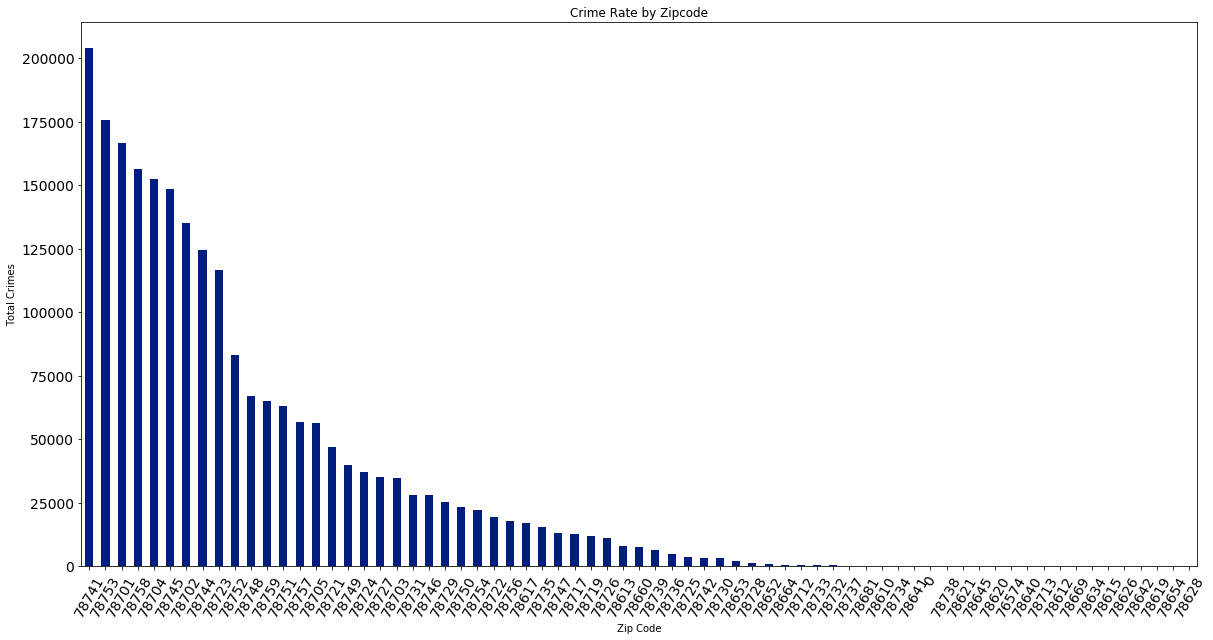

In [7]:
figsize = [20,10]

# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts()
display(zip_codes)
print('----------------------------------')
display(df.zip_code.value_counts(normalize=True))


df.zip_code.value_counts().plot.bar(fontsize=14, 
                                    figsize=figsize,   
                                    rot=60)

plt.xlabel('Zip Code')
plt.ylabel('Total Crimes')
plt.title('Crime Rate by Zipcode')
plt.show()

zip_off_desc = pd.crosstab(df.zip_code, 
                           df.highest_offense_description)

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.06%. This is a significant 1.3 percentage points higher than the number 2 area 78753 which hosts 7.8% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16920
BURGLARY OF VEHICLE               15759
FAMILY DISTURBANCE                14292
CRIMINAL MISCHIEF                  9241
THEFT BY SHOPLIFTING               7507
ASSAULT W/INJURY-FAM/DATE VIOL     7022
BURGLARY OF RESIDENCE              6005
DWI                                4874
DISTURBANCE - OTHER                4676
CUSTODY ARREST TRAFFIC WARR        4324
HARASSMENT                         4150
AUTO THEFT                         4048
POSS OF DRUG PARAPHERNALIA         3708
PUBLIC INTOXICATION                3341
ASSAULT WITH INJURY                3235
CRIMINAL TRESPASS                  3094
POSS CONTROLLED SUB/NARCOTIC       2932
RUNAWAY CHILD                      2891
WARRANT ARREST NON TRAFFIC         2785
POSSESSION OF MARIJUANA            2682
BURGLARY NON RESIDENCE             2444
VIOL CITY ORDINANCE - OTHER        1860
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096341
BURGLARY OF VEHICLE               0.089730
FAMILY DISTURBANCE                0.081377
CRIMINAL MISCHIEF                 0.052617
THEFT BY SHOPLIFTING              0.042744
ASSAULT W/INJURY-FAM/DATE VIOL    0.039982
BURGLARY OF RESIDENCE             0.034192
DWI                               0.027752
DISTURBANCE - OTHER               0.026625
CUSTODY ARREST TRAFFIC WARR       0.024620
HARASSMENT                        0.023630
AUTO THEFT                        0.023049
POSS OF DRUG PARAPHERNALIA        0.021113
PUBLIC INTOXICATION               0.019023
ASSAULT WITH INJURY               0.018420
CRIMINAL TRESPASS                 0.017617
POSS CONTROLLED SUB/NARCOTIC      0.016694
RUNAWAY CHILD                     0.016461
WARRANT ARREST NON TRAFFIC        0.015857
POSSESSION OF MARIJUANA           0.015271
BURGLARY NON RESIDENCE            0.013916
VIOL CITY ORDINANCE - OTHER       0.010591
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78753)')

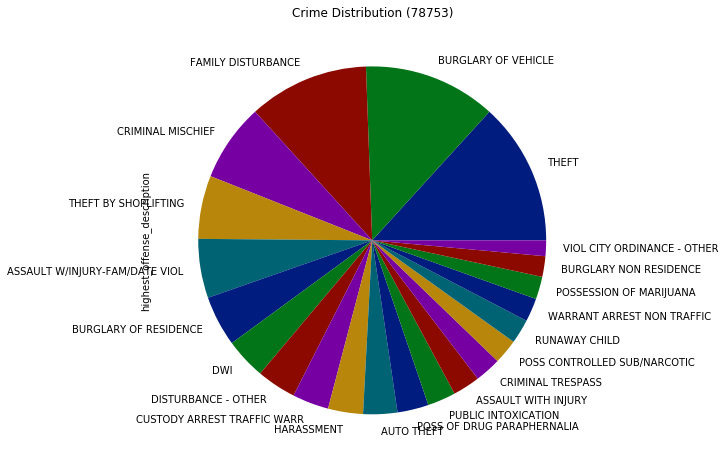

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                19974
BURGLARY OF VEHICLE               19622
THEFT                             15383
CRIMINAL MISCHIEF                 10880
ASSAULT W/INJURY-FAM/DATE VIOL     9541
BURGLARY OF RESIDENCE              8781
PUBLIC INTOXICATION                6356
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5603
HARASSMENT                         5416
DISTURBANCE - OTHER                5086
AUTO THEFT                         4480
ASSAULT WITH INJURY                4468
CRIMINAL TRESPASS                  3842
POSS CONTROLLED SUB/NARCOTIC       3817
POSSESSION OF MARIJUANA            3784
THEFT BY SHOPLIFTING               3545
POSS OF DRUG PARAPHERNALIA         3515
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2768
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.097995
BURGLARY OF VEHICLE               0.096268
THEFT                             0.075471
CRIMINAL MISCHIEF                 0.053379
ASSAULT W/INJURY-FAM/DATE VIOL    0.046809
BURGLARY OF RESIDENCE             0.043081
PUBLIC INTOXICATION               0.031183
CUSTODY ARREST TRAFFIC WARR       0.029491
DWI                               0.027489
HARASSMENT                        0.026572
DISTURBANCE - OTHER               0.024953
AUTO THEFT                        0.021979
ASSAULT WITH INJURY               0.021921
CRIMINAL TRESPASS                 0.018849
POSS CONTROLLED SUB/NARCOTIC      0.018727
POSSESSION OF MARIJUANA           0.018565
THEFT BY SHOPLIFTING              0.017392
POSS OF DRUG PARAPHERNALIA        0.017245
WARRANT ARREST NON TRAFFIC        0.016916
RUNAWAY CHILD                     0.013580
VIOL CITY ORDINANCE - OTHER       0.010769
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78741)')

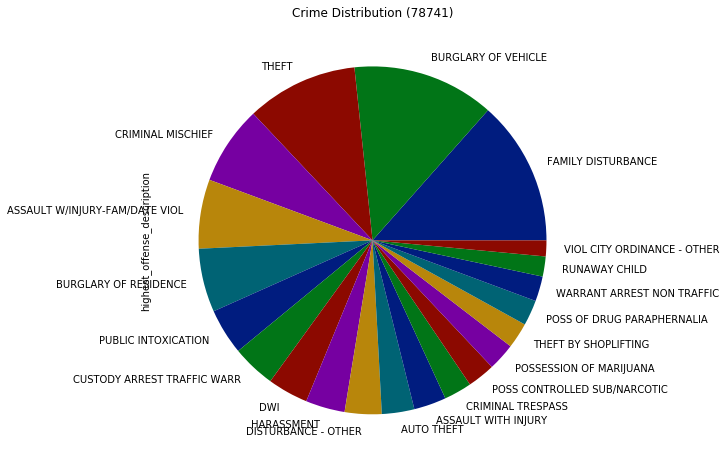

In [9]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

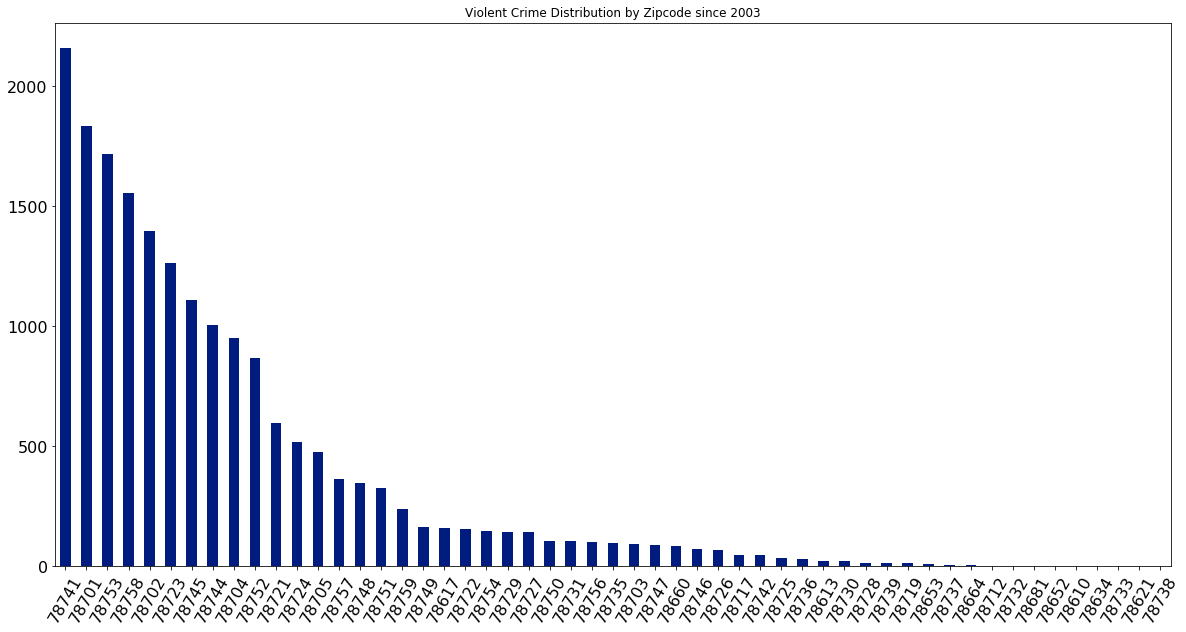

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610,1,0,0,0
78613,14,0,1,6
78617,117,0,6,36
78621,1,0,0,0
78634,1,0,0,0
78652,2,0,0,0
78653,8,0,1,1
78660,64,0,2,17
78664,3,0,0,0


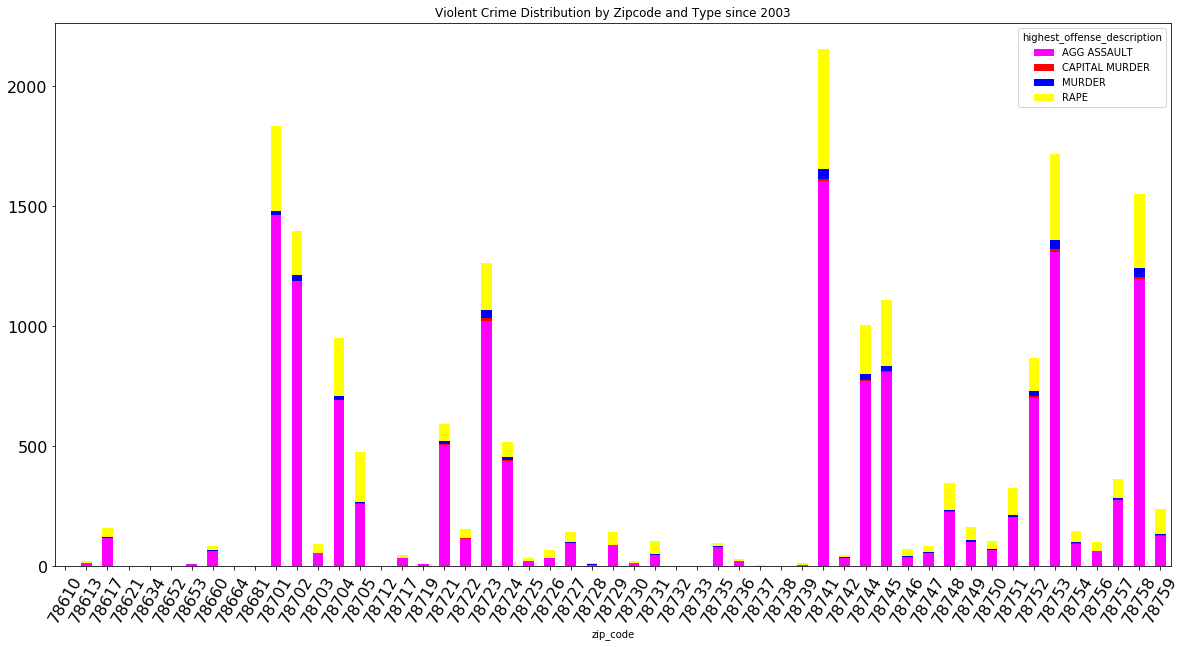

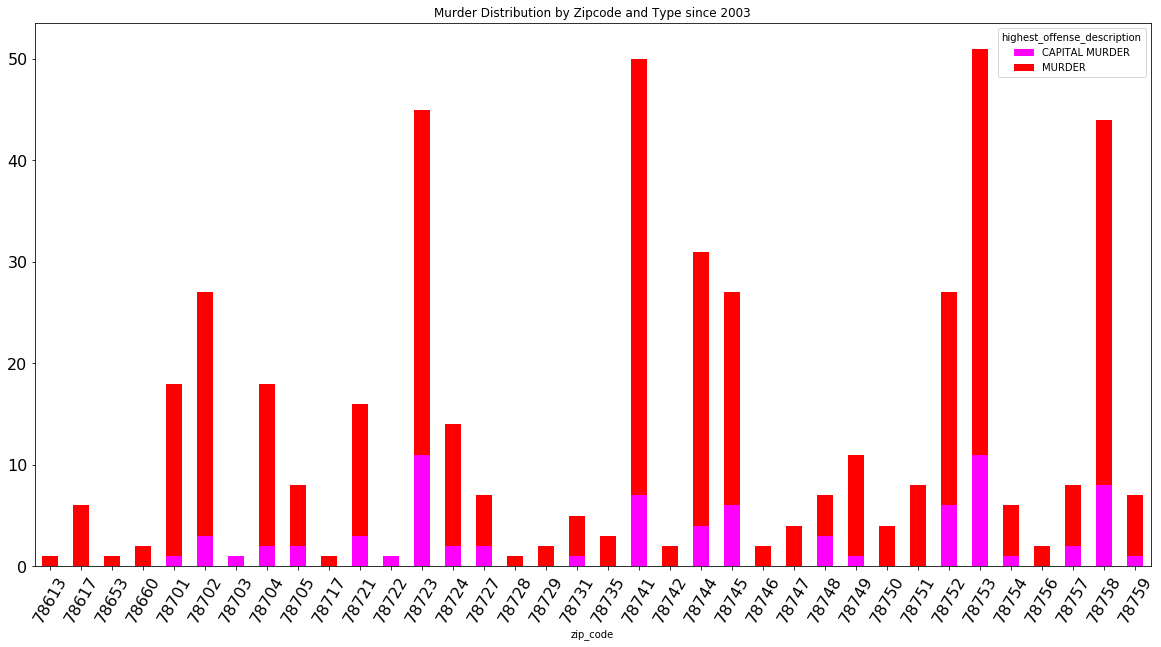

In [10]:
df_viol = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == 'MURDER']
df_mur_cap = df[df.highest_offense_description == 'CAPITAL MURDER']
df_agg_asslt = df[df.highest_offense_description == 'AGG ASSAULT']
df_rape = df[df.highest_offense_description == 'RAPE']

df_viol_zip = df_viol.zip_code.value_counts()

df_viol_zip.plot.bar(figsize=figsize, 
                     fontsize=16,  
                     rot=60)
plt.title('Violent Crime Distribution by Zipcode since 2003')
plt.show()

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
display(viol_freq)

viol_freq.plot.bar(stacked=True, 
                   figsize=figsize, 
                   color=color, 
                   fontsize=16,  
                   rot=60)
plt.title('Violent Crime Distribution by Zipcode and Type since 2003')
plt.show()

viol_mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
#display(viol_mur_freq)

viol_mur_freq.plot.bar(stacked=True, 
                       figsize=figsize,
                       fontsize=16, 
                       color=color,  
                       rot=60)
plt.title('Murder Distribution by Zipcode and Type since 2003')
plt.show()

<a id='q5'></a>
### E. Question 5. What significance has the family violence factor, in violent crime, played over time? 

0.07793944581149032

----------------------------------


report_date_time
2003    0.031461
2004    0.037428
2005    0.048591
2006    0.043393
2007    0.054319
2008    0.067379
2009    0.064317
2010    0.060918
2011    0.080472
2012    0.085149
2013    0.107514
2014    0.121305
2015    0.128151
2016    0.101449
2017    0.092965
2018    0.123711
2019    0.082155
2020    0.074627
Name: family_violence, dtype: float64

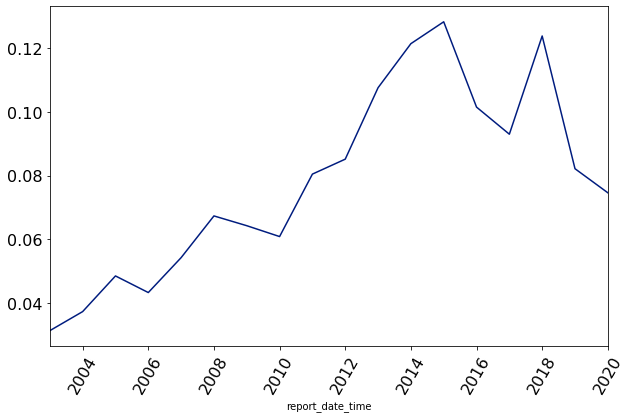

In [11]:
display(df_viol.family_violence.mean())

print('----------------------------------')
display(df_viol.groupby(df_viol.index.year).family_violence.mean())

hrly_fam_viol_occurrences = df_viol.groupby(df_viol.index.year).family_violence.mean()

fam_viol_avg = df_viol.groupby(df_viol.index.year).family_violence.mean()

fam_viol_avg.plot(rot=60, 
                  figsize=(10,6.25), 
                  fontsize=16)

plt.show()

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [12]:
# Create a geodataframe from the df_mur dataframe
gdf_mur = gp.GeoDataFrame(df_mur, 
                          geometry=gp.points_from_xy(df_mur.longitude, 
                                                     df_mur.latitude))

# ...df_mur_cap...
gdf_mur_cap = gp.GeoDataFrame(df_mur_cap, 
                              geometry=gp.points_from_xy(df_mur_cap.longitude, 
                                                         df_mur_cap.latitude))

In [13]:
gdf_mur.crs = {'init': 'epsg:3857'}
gdf_mur_cap.crs = {'init': 'epsg:3857'}

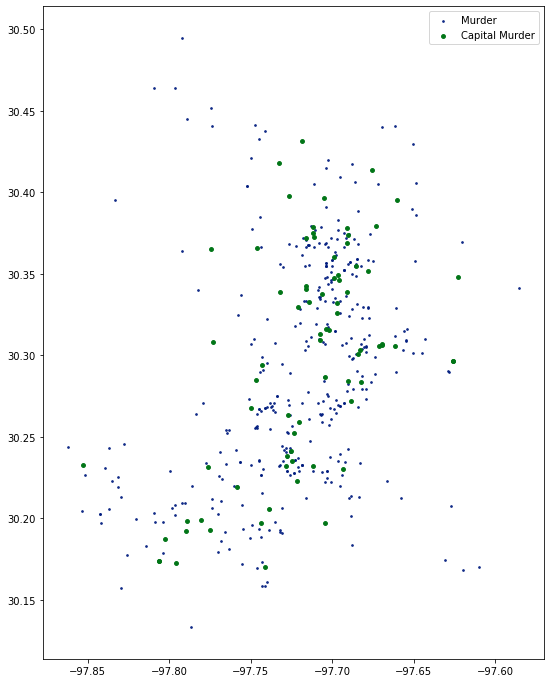

In [14]:
# Plot geodataframes on the "map"
ax = gdf_mur.plot(label='Murder', 
                  figsize=(12,12),  
                  alpha=0.85, 
                  markersize=3)  
gdf_mur_cap.plot(label='Capital Murder', 
                 figsize=(12,12),  
                 alpha=1, 
                 markersize=15, 
                 ax=ax)
ax.legend()

## IV. Summary
Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime.

For non-capital murder, 78741 comes in at number 1 with 10.91%. 

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

Regarding capital murder, 78723 comes in to share the number one spot with 78753, with a rate of 13.92% each. The 78741 area drops to the number 3 spot, carrying 8.97%. So, if we're honest, 78753 actually is the number 1 hotspot for murder because it has played host to 40 non-capital murders and 11 capital murders in total, meaning it has hosted 11% of all murders. 78741, if we combine all murders, only accounts for 10.56% of the total since 2003. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

A peculiar outlier is zipcode 78731. Although violent crime frequency ranks amongst the lowest there, rape accounts for over 50% of violent crimes committed in that area. Why is that? 

Astonishingly the family violence factor played an ever increasing role over over time, in regards to violent crime. From 2003 to 2015, family violence increased by nearly 10 percentage points--meaning you were likely to be the victim of a family member, during the commission of a rape, aggrivated assault, murder, or capital murder, only 3.15% of the time in 2003. But by 2015, that same likelihood rose to 12.82%!